In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,LSTM
# from keras.layers import LSTM

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn

import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]

# Loading and preprocessing the raw data to a .csv file-

In [4]:
# The data is given in the form of .txt files. Here we convert the data into a .csv file 
# and save it under the 'train' and 'test' directories for further use. Also the data here is 
# arranged according to the subject ID. Therefore to break any correlation that may exists 
# between the datapoints, we shuffle the dataset before dividing it into public and private 
# datasets to be used in the Neural Network model.
features = []
with open("./UCI HAR Dataset/features.txt") as file:
    for line in file:
        features.append(line.split()[1])
        
# Renaming duplicate column names
names = []
count = {}
for feature in features:
    if(features.count(feature) > 1):
        names.append(feature)
for name in names:
    count[name] = features.count(name)

for i in range(len(features)):
    if(features[i] in names):
        num = count[features[i]]
        count[features[i]] -= 1;
        features[i] = str(features[i] + str(num))
        
train_df = pd.read_csv("./UCI HAR Dataset/train/X_train.txt", delim_whitespace = True,names= features)
train_df['subject_id'] = pd.read_csv("./UCI HAR Dataset/train/subject_train.txt",header= None,squeeze=True)
train_df["activity"] = pd.read_csv("./UCI HAR Dataset/train/y_train.txt", header = None, squeeze = True)
activity = pd.read_csv("./UCI HAR Dataset/train/y_train.txt", header = None, squeeze = True)
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
train_df["activity_name"] = label_name
train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [5]:
test_df = pd.read_csv("./UCI HAR Dataset/test/X_test.txt", delim_whitespace = True, names = features)
test_df['subject_id'] = pd.read_csv("./UCI HAR Dataset/test/subject_test.txt",header= None,squeeze=True)
test_df["activity"] = pd.read_csv("./UCI HAR Dataset/test/y_test.txt", header = None, squeeze = True)
activity = pd.read_csv("./UCI HAR Dataset/test/y_test.txt", header = None, squeeze = True)
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})
test_df["activity_name"] = label_name
test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,5,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,5,STANDING


# Saving train and test data to a resuable .csv file-

In [6]:
train_df = shuffle(train_df)
test_df = shuffle(test_df)
train_df.to_csv("./UCI HAR Dataset/train/train.csv", index = False)
test_df.to_csv("./UCI HAR Dataset/test/test.csv", index = False)

# Loading the data from the .csv file-

In [7]:
train_df = pd.read_csv('./UCI HAR Dataset/train/train.csv')
test_df = pd.read_csv('./UCI HAR Dataset/test/test.csv')
train_df['activity'] -= 1;
test_df['activity'] -= 1;

y_train = train_df['activity']
X_train = train_df.drop(['activity','activity_name','subject_id'],axis=1)
y_test = test_df['activity']
X_test = test_df.drop(['activity','activity_name','subject_id'],axis=1)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [9]:
X_train = pd.concat([X_train,X_test], axis = 0)
y_train = pd.concat([y_train,y_test], axis = 0)

X_train.shape, y_train.shape

((10299, 561), (10299,))

# Global variables and Function declarations-

In [10]:
# Variables-
epochs = 30
# batch_size = 64
batch_size = 16
num_classes = 6
fig_size = (9,7)

In [11]:
def CREATE_MODEL(input_shape):
    model = Sequential()
    model.add(Input(shape = input_shape,))
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu'))
    model.add(Dense(num_classes,activation='softmax'))
    return model

def COMPILE(model):
    model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model;
    
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

def CONFUSION_MATRIX(y_test, y_pred):
    confusionMatrix = confusion_matrix(y_test, y_pred)
    sns.set(font_scale=1.5)
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Global Model Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 45)
    plt.show()

In [116]:
def Model(X, y, n):
    X, y = np.array(X), np.array(y)

    model = CREATE_MODEL(X.shape[1])
    print(model.summary())


    model = COMPILE(model)
    history, model = FIT(model, X, y, n)

    PLOT(history, n)

    print(history.history['accuracy'])
    print(max(history.history['accuracy']))
    
    return model


def data(X, Y, path):
#     path = 'Real-Time'
    
    test_x = pd.read_csv('{0}/{1}'.format(path, X))
    test_y = pd.read_csv('{0}/{1}'.format(path, Y))

    scaler = MinMaxScaler(feature_range = [-1,1])
    test_x  = scaler.fit_transform(test_x)
        
    return test_x, np.array(test_y)



def check(clf, X, y, X_test, y_test):
    clf.fit(X, y.ravel())
        
    y_predicted = clf.predict(X_test)
    
    recall = metrics.recall_score(y_test, y_predicted, average='macro' )
    precision = metrics.precision_score(y_test, y_predicted, average='macro' )
    f_score = metrics.f1_score(y_test, y_predicted, average="macro") 

    print(round(recall,4) * 100, 'Recall')
    print(round(precision, 4)*100, 'pre')
    print(round(f_score, 4)*100, "fscore")
    print('Accuracy is: ', metrics.accuracy_score(y_test, y_predicted))
    
    array = confusion_matrix(y_test,y_predicted)
    
    df_cm = pd.DataFrame(array, index = [i for i in LABELS],
                    columns = [i for i in LABELS])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="BuPu",fmt='g')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

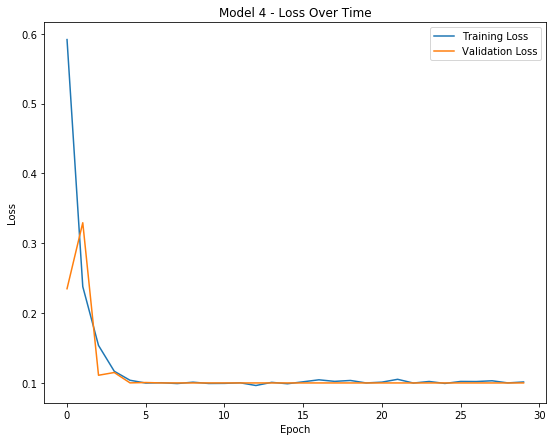

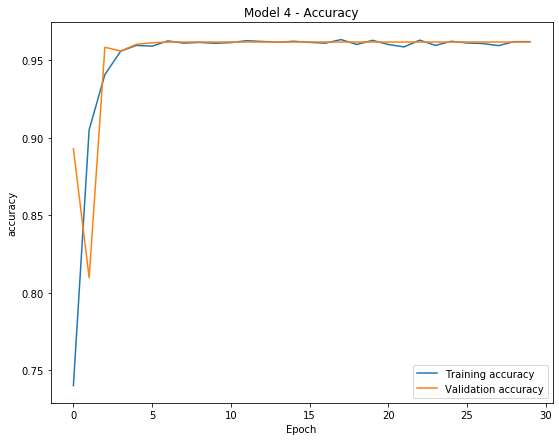

[0.74013835, 0.90508556, 0.94064814, 0.9556985, 0.9594611, 0.9589756, 0.9623741, 0.9609176, 0.9614031, 0.96079624, 0.9612817, 0.96249545, 0.96200997, 0.9615245, 0.9621313, 0.9614031, 0.9609176, 0.9632237, 0.960068, 0.9627382, 0.960068, 0.95849013, 0.9628596, 0.9594611, 0.9621313, 0.96103895, 0.9606748, 0.95933974, 0.96188855, 0.96188855]
0.9632237


In [13]:
model = Model(X_train, y_train, 4)

In [14]:
# X_test, y_test = np.array(X_test), np.array(y_test)

# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred,axis=1)

# print('Accuracy is: ',metrics.accuracy_score(y_pred, y_test))

# CONFUSION_MATRIX(y_test,y_pred)

In [15]:
model.pop()

In [16]:
model.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [18]:
# model = COMPILE(model)

In [119]:
def data2(trainX, trainY, testX, testY,  path):
#     path = 'Real-Time'
    
    train_x = pd.read_csv('{0}/{1}'.format(path, trainX))
    train_y = pd.read_csv('{0}/{1}'.format(path, trainY))
    
    test_x = pd.read_csv('{0}/{1}'.format(path, testX))
    test_y = pd.read_csv('{0}/{1}'.format(path, testY))

    scaler = MinMaxScaler(feature_range = [-1,1])
    
    train_x  = scaler.fit_transform(train_x)
    test_x  = scaler.fit_transform(test_x)
    
        
    return train_x, np.array(train_y) -1, test_x, np.array(test_y)-1


In [221]:
# X_test_real, y_test_real = data('X.csv', 'Y.csv', 'Real-Time')

# path = 'Real-time_v1'
# X, y = data('X.csv', 'Y.csv', path)
# y -= 1
# X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X, y, test_size=0.33, random_state=42)


path = 'Real-time_augmented'
X_train_real, y_train_real, X_test_real, y_test_real = data2('X_jit_scal_train.csv', 'y_jit_scal_train.csv','X_test.csv', 'y_test.csv', path)


X_train_real = model.predict(X_train_real)
X_test_real = model.predict(X_test_real)

X_train_real.shape, X_test_real.shape, y_train_real.shape, y_test_real.shape

((372, 32), (66, 32), (372, 1), (66, 1))

In [222]:
X_train_real.shape

(372, 32)

In [223]:
((176, 32), (88, 32), (176, 1), (88, 1))

((176, 32), (88, 32), (176, 1), (88, 1))

# SVM

81.94 Recall
83.2 pre
80.03 fscore
Accuracy is:  0.8181818181818182


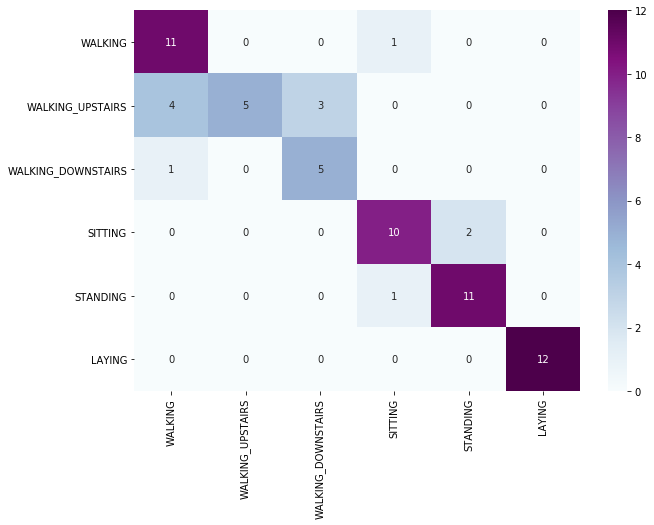

In [224]:
svm = SVC(C = 10, gamma = 0.01, kernel= 'rbf')
check(svm, X_train_real, y_train_real, X_test_real, y_test_real)

77.78 Recall
76.09 pre
76.17 fscore
Accuracy is:  0.7727272727272727


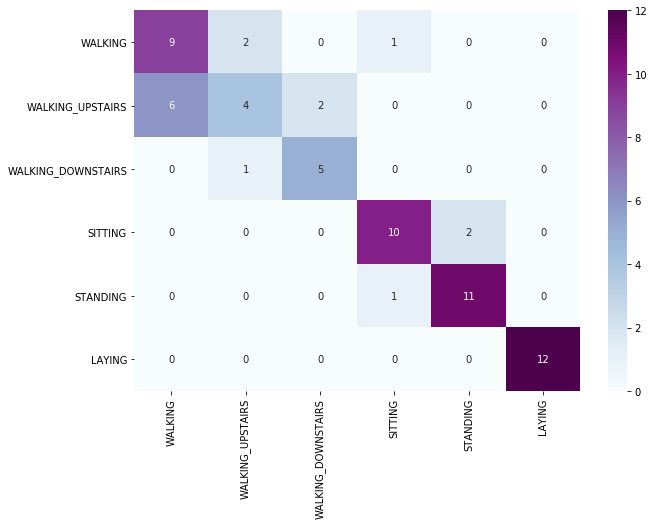

In [225]:
svm = SVC(C = 0.001, gamma = 0.1, kernel= 'poly')
check(svm, X_train_real, y_train_real, X_test_real, y_test_real)

In [226]:
def svc_param_selection(X, y, nfolds):

    param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1], 
                  'gamma' : [0.01, 0.1, 1], 
                  'kernel': ['linear', 'poly', 'rbf', 'sigmoid'] }


    grid_search = GridSearchCV( SVC(), 
                             param_grid, 
                             cv = nfolds,
                             n_jobs = -1) # use all processor
    grid_search.fit(X, y.ravel())

    return grid_search.best_params_

# svc_param_selection(X, y, 5)

# KNN

68.06 Recall
71.93 pre
65.34 fscore
Accuracy is:  0.6818181818181818


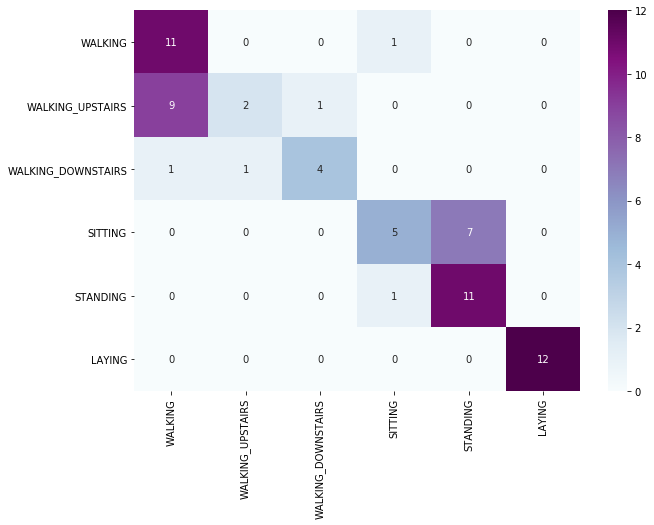

In [227]:
knn = KNeighborsClassifier(metric= 'manhattan', n_neighbors = 5, weights = 'distance')
check(knn, X_train_real, y_train_real, X_test_real, y_test_real)

In [228]:
def knn_param_selection(X, y, nfolds):

    param_grid = {'n_neighbors' : [3,5,7,11,13,15,19,21],
                'weights' : ['uniform', 'distance'], 
                'metric' : ['euclidean','manhattan'] }

    grid_search = GridSearchCV(KNeighborsClassifier(), 
                             param_grid, 
                             cv = nfolds,
                             n_jobs = -1)

    grid_search.fit(X,y)

    return grid_search.best_params_
                  
# knn_param_selection(X, y.ravel(), 5)

# Random Forest

73.61 Recall
76.0 pre
72.39 fscore
Accuracy is:  0.7424242424242424


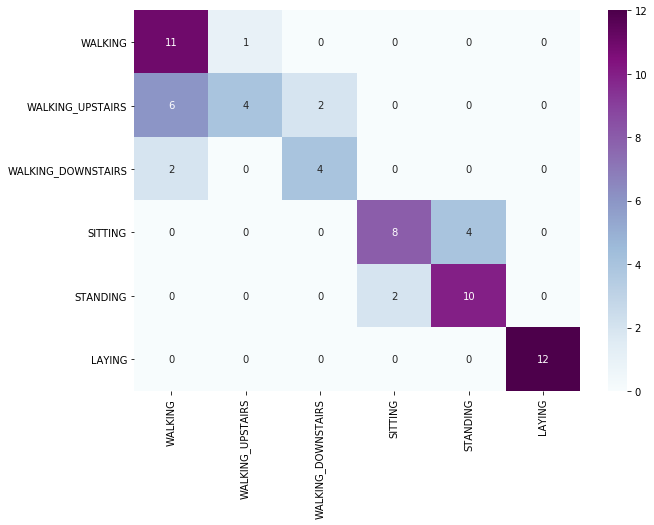

In [229]:
rf = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 6, n_estimators = 50)
check(rf, X_train_real, y_train_real, X_test_real, y_test_real)

68.06 Recall
70.54 pre
65.24 fscore
Accuracy is:  0.6818181818181818


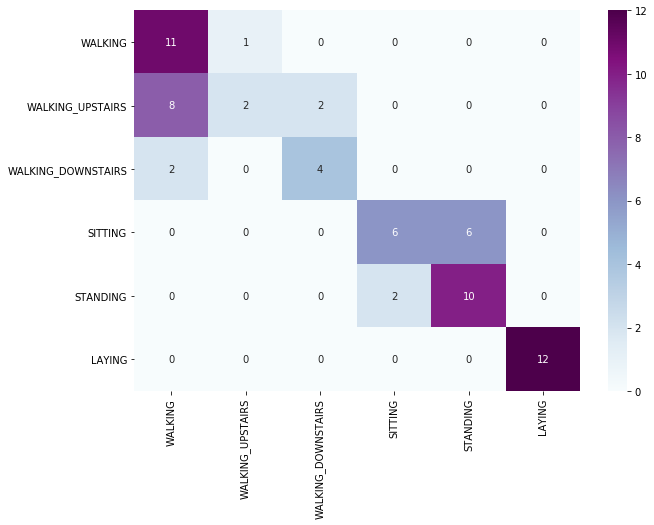

In [230]:
rf = RandomForestClassifier(max_features= 'sqrt', min_samples_split= 6, n_estimators = 40)
check(rf, X_train_real, y_train_real, X_test_real, y_test_real)

In [174]:
def rf_param_selection(X, y, nfolds):
    param_grid = {'n_estimators': [40, 50, 150],
                'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
                'min_samples_split': [4, 6,8, 10]}

    grid_search = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             cv = nfolds,
                             n_jobs = -1)
    grid_search.fit(X, y)

    return grid_search.best_params_

# rf_param_selection(X, y.ravel(), 5)

# CNN

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)               

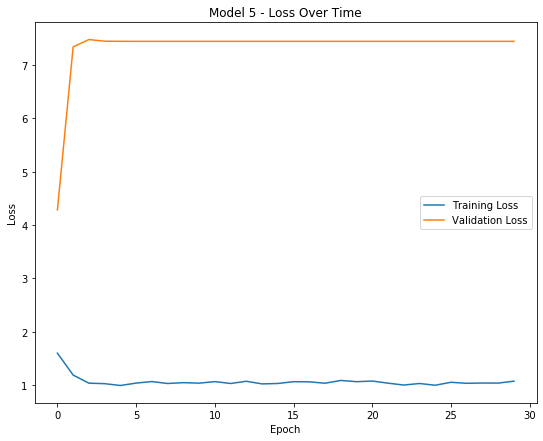

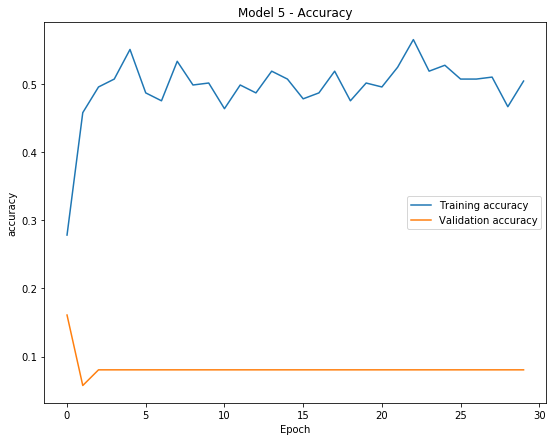

[0.27826086, 0.457971, 0.49565217, 0.5072464, 0.5507246, 0.4869565, 0.47536233, 0.53333336, 0.4985507, 0.5014493, 0.46376812, 0.4985507, 0.4869565, 0.51884055, 0.5072464, 0.47826087, 0.4869565, 0.51884055, 0.47536233, 0.5014493, 0.49565217, 0.5246377, 0.5652174, 0.51884055, 0.5275362, 0.5072464, 0.5072464, 0.51014495, 0.46666667, 0.5043478]
0.5652174


In [102]:
cnn = Model(X_train_real, y_train_real, 5)

In [23]:
y_pred = cnn.predict(X_test_real)
y_pred = np.argmax(y_pred,axis=1)

In [24]:
recall = metrics.recall_score(y_test_real, y_pred, average='macro' )
precision = metrics.precision_score(y_test_real, y_pred, average='macro' )
f_score = metrics.f1_score(y_test_real, y_pred, average="macro") 

print(round(recall,4) * 100, 'Recall')
print(round(precision, 4)*100, 'pre')
print(round(f_score, 4)*100, "fscore")
print('Accuracy is: ', metrics.accuracy_score(y_test_real, y_pred))

65.16999999999999 Recall
64.67 pre
63.55 fscore
Accuracy is:  0.6363636363636364


# LSTM

In [231]:
X_train_lstm = np.reshape(X_train_real, (X_train_real.shape[0], 1, X_train_real.shape[1]))
X_test_lstm = np.reshape(X_test_real, (X_test_real.shape[0], 1, X_test_real.shape[1]))

In [232]:
def LSTM_Model(trainX, trainY, testX, testY):
    n_steps = 32
    n_feature = 1
    verbose, epochs, batch_size = 0, 50, 64

    lstm = Sequential()
    lstm.add(LSTM(units= trainX.shape[0], input_shape=(n_feature, n_steps) ))
    lstm.add(Dense(128, activation='relu'))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(64, activation='relu'))
#     lstm.add(Dropout(0.2))
#     lstm.add(Dense(64, activation='relu'))
    lstm.add(Dense(6, activation='softmax'))

    print(lstm.summary())

    lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    
    lstm.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)


    _, accuracy = lstm.evaluate(testX, testY, batch_size=batch_size, verbose=0)
    
    y_pred = lstm.predict(testX)
    y_pred = np.argmax(y_pred,axis=1)
    
    recall = metrics.recall_score(testY, y_pred, average='macro' )
    precision = metrics.precision_score(testY, y_pred, average='macro' )
    f_score = metrics.f1_score(testY, y_pred, average="macro") 

    print(round(recall,4) * 100, 'Recall')
    print(round(precision, 4)*100, 'pre')
    print(round(f_score, 4)*100, "fscore")
    print('Accuracy is: ', metrics.accuracy_score(testY, y_pred))
    
    array = confusion_matrix(testY, y_pred)
    
    df_cm = pd.DataFrame(array, index = [i for i in LABELS],
                    columns = [i for i in LABELS])
    
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap="BuPu",fmt='g')

    return accuracy

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 372)               602640    
_________________________________________________________________
dense_65 (Dense)             (None, 128)               47744     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 6)                 390       
Total params: 659,030
Trainable params: 659,030
Non-trainable params: 0
_________________________________________________________________
None
81.94 Recall
84.27 pre
80.53 fscore
Accuracy is:  0.8181818181818182


0.8181818

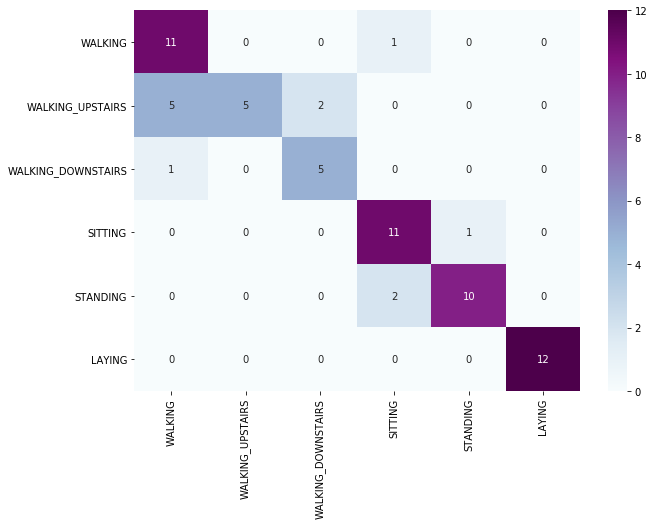

In [233]:
LSTM_Model(X_train_lstm, y_train_real, X_test_lstm, y_test_real )

In [25]:
X_train_test = model.predict(X_train)
X_test_test = model.predict(X_test)

X_train_test = np.reshape(X_train_test, (X_train_test.shape[0], 1, X_train_test.shape[1]))
X_test_test = np.reshape(X_test_test, (X_test_test.shape[0], 1, X_test_test.shape[1]))

In [ ]:
LSTM_Model(X_train, y_train, X_test, y_test)

# Feature extracted by my Code

In [ ]:
scaler = MinMaxScaler(feature_range = [-1,1])

X_train_fex = pd.read_csv("TRAIN_NEW_ALL.csv")
X_test_fex = pd.read_csv("TEST_NEW_ALL.csv")

X_train_fex = scaler.fit_transform(X_train_fex)
X_test_fex  = scaler.fit_transform(X_test_fex)

X_train_fex = pd.DataFrame(X_train_fex)
X_test_fex = pd.DataFrame(X_test_fex)

print(X_train_fex.shape, X_test_fex.shape)


y_train_fex = pd.read_csv("UCI HAR Dataset/train/y_train.txt", delim_whitespace=True, header=None)[:-1]
y_test_fex = pd.read_csv("UCI HAR Dataset/test/y_test.txt", delim_whitespace=True, header=None)[:-1]

print(y_train.shape, y_test.shape)


y_train_fex -= 1
y_test_fex -= 1

In [ ]:
model_extracted = Model(X_train_fex, y_train_fex, 5)

In [ ]:
model_extracted.pop()
model_extracted.trainable = True

model_extracted.summary()

In [ ]:
X, y = data('X.csv', 'Y.csv', 'Real-time_v1')
X = model_extracted.predict(X)

svm = SVC(C = 10, gamma = 0.01, kernel= 'rbf')
check(svm, X, y, X, y)

# Model replica number-1 

In [ ]:
# MODEL REPLICA NO.1
X_train_1 = X_train[0:2500]
y_train_1 = y_train[0:2500]

In [ ]:
X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);

In [ ]:
model_1 = CREATE_MODEL(X_train_1.shape[1]);
model_1.summary()

In [ ]:
model_1 = COMPILE(model_1)
history_1,model_1 = FIT(model_1,X_train_1,y_train_1,1)

In [ ]:
PLOT(history_1,1)

# Model replica number-2

In [ ]:
# MODEL REPLICA NO.2
X_train_2 = X_train[2500:5000]
y_train_2 = y_train[2500:5000]

In [ ]:
X_train_2, y_train_2 = PREPROCESS(X_train_2,y_train_2)

In [ ]:
model_2 = CREATE_MODEL(X_train_2.shape[1])
model_2.summary()

In [ ]:
model_2 = COMPILE(model_2)
history_2,model_2 = FIT(model_2,X_train_2,y_train_2,2);

In [ ]:
PLOT(history_2,2);

# Model replica number-3

In [ ]:
# MODEL REPLICA NO.3
X_train_3 = X_train[5000:-1]
y_train_3 = y_train[5000:-1]

In [ ]:
X_train_3, y_train_3 = PREPROCESS(X_train_3,y_train_3)

In [ ]:
model_3 = CREATE_MODEL(X_train_3.shape[1])
model_3.summary()

In [ ]:
model_3 = COMPILE(model_3);
history_3, model_3 = FIT(model_3,X_train_3,y_train_3,3)

In [ ]:
PLOT(history_3,3)

# The global model

In [ ]:
model_g = CREATE_MODEL(X_test.shape[1])
model_g.summary()

In [ ]:
all_models = []
LOAD_MODELS()

In [ ]:
weights = [max(history_1.history['accuracy']), max(history_2.history['accuracy']), max(history_3.history['accuracy'])]
x = max(weights)
idx = weights.index(x)
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.02
for i in range(3):
    if(weights[i] != 1 and weights[i] != 0.02):
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [ ]:
model_g.set_weights(avg_model_weights)
model_g = COMPILE(model_g)
_ , accuracy = model_g.evaluate(X_test,y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

In [ ]:
y_pred = model_g.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
CONFUSION_MATRIX(y_test,y_pred)